In [259]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from matplotlib import animation
import matplotlib.cm as cm
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import scipy.io.wavfile as wavfile
import subprocess

0

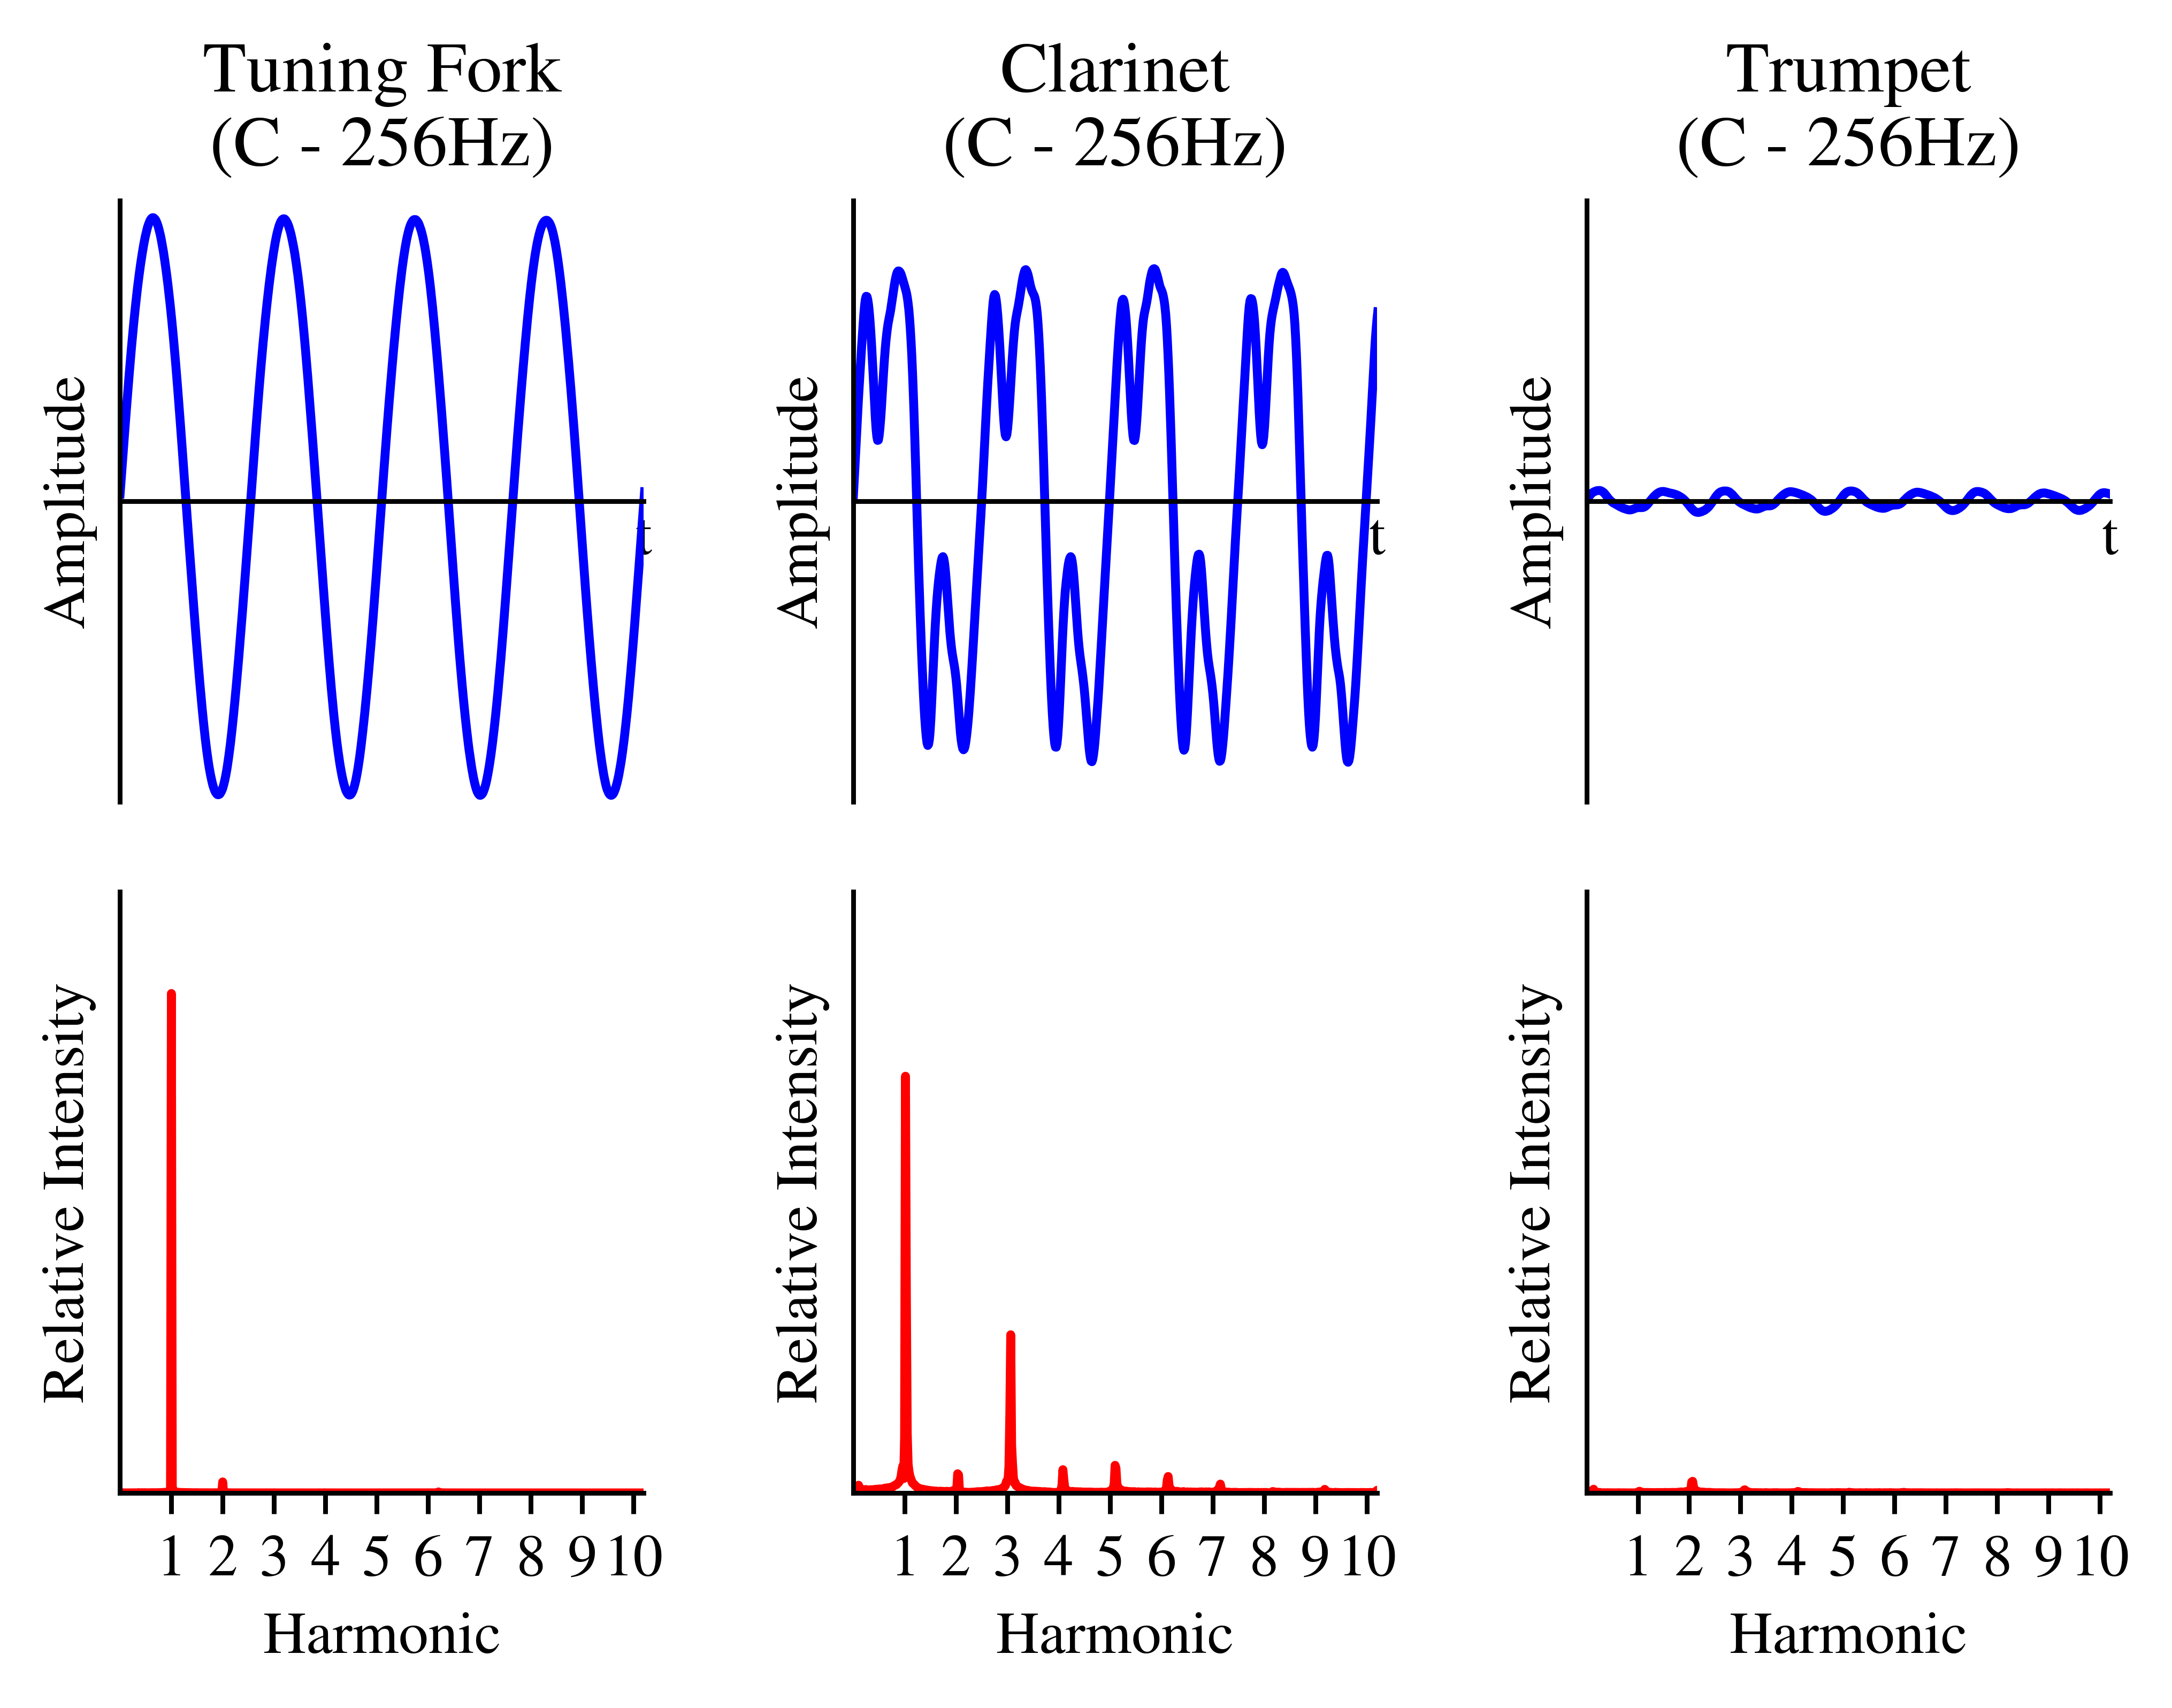

In [271]:
plot_width = int(4*44100//256)
sample_width = 10000

zero = np.zeros(sample_width, dtype=np.int16)
x_count = np.arange(sample_width)

f_fs, f_data = wavfile.read('fork_trimmed.wav')
f_data_cut = f_data[30000:60000]
f_plot_max = 3903
f_spec_max = 18463477.81086587 #This is just lazy scaling



t_fs, t_data = wavfile.read('trumpet.wav')
t_data_cut = t_data[30000:60000]
t_plot_max = 6172
t_spec_max = 10359584.694195159

c_fs, c_data = wavfile.read('clarinet.wav')
c_data_cut = c_data[30000:60000]
c_plot_max = 3149
c_spec_max = 9358976.153688183


harmonics = np.fft.rfftfreq(sample_width, d=1/float(44100))/256.0


def harmonic_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False,
        color='black',
        direction='in')
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labeltop=False,
        color='black')
    ax.set_ylabel("Relative Intensity")
    ax.set_xlabel("Harmonic")
    ax.set_xlim(0, 10.2)
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], minor=False) 


    
def amplitude_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False,
        color='black',
        direction='in')
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,
        labelbottom=False, # ticks along the top edge are off
        color='black')
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("t")
    ax.spines['bottom'].set_position('zero')
    ax.xaxis.set_label_coords(1.0, 0.48)
    
    

f1, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), dpi=800)

axes[0, 0].set_title("Tuning Fork\n(C - 256Hz)")

f_amp, = axes[0, 0].plot([],[], color='b')
f_spec, = axes[1,0].plot([],[], color='r')

amplitude_format(axes[0,0])
axes[0, 0].set_xlim(0, plot_width)
axes[0, 0].set_ylim(-f_plot_max, f_plot_max)
harmonic_format(axes[1,0])
axes[1, 0].set_ylim(0, 1.2)


axes[0, 1].set_title("Clarinet\n(C - 256Hz)")

c_amp, = axes[0, 1].plot([],[], color='b')
c_spec, = axes[1,1].plot([],[], color='r')


amplitude_format(axes[0,1])
axes[0, 1].set_xlim(0, plot_width)
axes[0, 1].set_ylim(-c_plot_max, c_plot_max)
harmonic_format(axes[1,1])
axes[1, 1].set_ylim(0, 1.2)




axes[0, 2].set_title("Trumpet\n(C - 256Hz)")

t_amp, = axes[0, 2].plot([],[], color='b')
t_spec, = axes[1,2].plot([],[], color='r')


amplitude_format(axes[0,2])
axes[0, 2].set_xlim(0, plot_width)
axes[0, 2].set_ylim(-t_plot_max, t_plot_max)
harmonic_format(axes[1,2])
axes[1, 2].set_ylim(0, 1.2)

#f1.tight_layout()
f1.subplots_adjust(wspace=0.4, hspace=0.15)

def init():

    c_amp.set_data([],[])
    c_spec.set_data([],[])
    t_amp.set_data([],[])
    t_spec.set_data([],[])
    f_amp.set_data([],[])
    f_spec.set_data([],[])

    return c_amp, c_spec, t_amp, t_spec, f_amp, f_spec

#assume 20 frames per second
fps = 20
max_i = 19
c_freq = 256
audio_sample_rate = 44100 #this is true for these files, but can be read from .wav
samp_per_frame = audio_sample_rate/fps
samples_per_cycle = audio_sample_rate/c_freq
trigger_val = 0.0

f_stop = int(fps*(len(f_data)-sample_width)//44100)
c_stop = f_stop + int(fps*(len(c_data)-sample_width)//44100)
t_stop = c_stop + int(fps*(len(t_data)-sample_width)//44100) 

def animate(i):
    
    if i < f_stop:
        samp_i = int((i*samp_per_frame)//1)

        f_window = f_data[samp_i:samp_i+sample_width]
        f_fft = np.abs(np.fft.rfft(f_window))/f_spec_max
        offset_f = (np.flatnonzero((f_window[:-1] < trigger_val) & (f_window[1:] > trigger_val))+1)[0]
        #use oscilliscope like trigger for offset
        f_amp.set_data(x_count[:sample_width-offset_f], f_window[offset_f:])
        f_spec.set_data(harmonics, f_fft)

    if (i >= f_stop and i < c_stop):
        samp_i = int(((i-f_stop)*samp_per_frame)//1)
        c_window = c_data[samp_i:samp_i+sample_width]
        c_fft = np.abs(np.fft.rfft(c_window))/c_spec_max

        offset_c = (np.flatnonzero((c_window[:-1] < trigger_val) & (c_window[1:] > trigger_val))+1)[0]
        #use oscilliscope like trigger for offset
        c_amp.set_data(x_count[:sample_width-offset_c], c_window[offset_c:])
        c_spec.set_data(harmonics, c_fft)

    if (i >=c_stop and i < t_stop):
        samp_i = int(((i-c_stop)*samp_per_frame)//1)
        t_window = t_data[samp_i:samp_i+sample_width]
        t_fft = np.abs(np.fft.rfft(t_window))/t_spec_max

        offset_t = (np.flatnonzero((t_window[:-1] < trigger_val) & (t_window[1:] > trigger_val))+1)[0]
        #use oscilliscope like trigger for offset
        t_amp.set_data(x_count[:sample_width-offset_t], t_window[offset_t:])
        t_spec.set_data(harmonics, t_fft)
    
    
    return c_amp, c_spec, t_amp, t_spec, f_amp, f_spec

anim = animation.FuncAnimation(f1, animate, init_func=init,
                               frames=t_stop, interval=50, blit=True)
anim.save('v_only.mp4', fps=20)

subprocess.call(['ffmpeg', '-hide_banner','-loglevel','panic','-i', 'v_only.mp4', '-i', 'combined_audio.wav', '-c:v', 
                               'copy', '-c:a', 'aac', '-strict', 'experimental', 'spec_analysis_audio.mp4'])

0